In [1]:
import torch
import torchvision
import torch.nn.functional as F

import numpy as np
import pandas as pd

# import matplotlib.pyplot as plt
# %matplotlib inline

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# # Linux操作系统
# !wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf -O /environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/simHei.ttf
# !rm -rf /home/featurize/.cache/matplotlib

# import matplotlib
# matplotlib.rc("font",family='simhei') # 中文字体

# # # # windows操作系统
# # # plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签 
# # # plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [3]:
from PIL import Image, ImageFont, ImageDraw
# 导入中文字体，指定字号
# font = ImageFont.truetype('simhei.ttf', 70)
font = ImageFont.truetype('simhei.ttf', 16)

In [4]:
# 载入类别
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()

In [5]:
# 导入训练好的模型
model = torch.load('checkpoint/music_pytorch_C1.pth')
model = model.eval().to(device)

In [6]:
# 预处理
from torchvision import transforms
# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

In [7]:
# 载入一张测试图像
from PIL import Image
# img_path = 'music/val/saxophone/path105.jpg'
# img_path = 'music/val/violin/path100.jpg'
img_path = 'music/val/piano/path414.jpg'
# img_path = 'music/val/guiter/path142.jpg'
# img_path = 'music/val/guiter/path133.jpg'

img_pil = Image.open(img_path)

In [8]:
# 预处理前向预测
input_img = test_transform(img_pil) # 预处理
input_img = input_img.unsqueeze(0).to(device)
# 执行前向预测，得到所有类别的 logit 预测分数
pred_logits = model(input_img) 
pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算

In [9]:
# plt.figure(figsize=(22, 10))

# x = idx_to_labels.values()
# y = pred_softmax.cpu().detach().numpy()[0] * 100
# width = 0.45 # 柱状图宽度

# ax = plt.bar(x, y, width)

# plt.bar_label(ax, fmt='%.3f', fontsize=15) # 置信度数值
# plt.tick_params(labelsize=20) # 设置坐标文字大小

# plt.title(img_path, fontsize=30)
# plt.xticks(rotation=0) # 横轴文字旋转
# plt.xlabel('类别', fontsize=20)
# plt.ylabel('置信度', fontsize=20)
# plt.show()

In [10]:
# 置信度最大的前n个结果
n = 5
top_n = torch.topk(pred_softmax, n) # 取置信度最大的 n 个结果
pred_ids = top_n[1].cpu().detach().numpy().squeeze() # 解析出类别
confs = top_n[0].cpu().detach().numpy().squeeze() # 解析出置信度

In [11]:
# 图像分类结果写在原图上
draw = ImageDraw.Draw(img_pil)
for i in range(n):
    class_name = idx_to_labels[pred_ids[i]] # 获取类别名称
    confidence = confs[i] * 100 # 获取置信度
    text = '{:<5} {:>.3f}'.format(class_name, confidence) # 保留 3 位小数
    print(text)
    
    # 文字坐标，中文字符串，字体，rgba颜色
    # draw.text((50, 100 + 50 * i), text, font=font, fill=(255, 0, 0, 1))
    draw.text((10, 20+20*i), text, font=font, fill=(204, 0, 0, 1))
    # draw.text((10, 20+85*i), text, font=font, fill=(204, 0, 0, 1))

piano 99.881
guzhen 0.112
drum  0.003
violin 0.003
guiter 0.000


In [12]:
 drawpath = 'output/draw.jpg'
img_pil.save(drawpath)

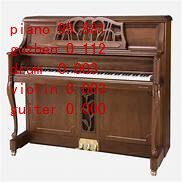

In [13]:
img_pil

In [14]:
# fig = plt.figure(figsize=(18,6))

# # 绘制左图-预测图
# ax1 = plt.subplot(1,2,1)
# ax1.imshow(img_pil)
# ax1.axis('off')

# # 绘制右图-柱状图
# ax2 = plt.subplot(1,2,2)
# x = idx_to_labels.values()
# y = pred_softmax.cpu().detach().numpy()[0] * 100
# ax2.bar(x, y, alpha=0.5, width=0.3, color='yellow', edgecolor='red', lw=3)
# plt.bar_label(ax, fmt='%.3f', fontsize=10) # 置信度数值

# plt.title('{} 图像分类预测结果'.format(img_path), fontsize=30)
# plt.xlabel('类别', fontsize=20)
# plt.ylabel('置信度', fontsize=20)
# plt.ylim([0, 110]) # y轴取值范围
# ax2.tick_params(labelsize=16) # 坐标文字大小
# plt.xticks(rotation=0) # 横轴文字旋转

# plt.tight_layout()
# fig.savefig('output/预测图+柱状图.jpg')

In [15]:
# pred_df = pd.DataFrame() # 预测结果表格
# for i in range(n):
#     class_name = idx_to_labels[pred_ids[i]] # 获取类别名称
#     label_idx = int(pred_ids[i]) # 获取类别号
#     confidence = confs[i] * 100 # 获取置信度
#     new_row = {'Class': class_name, 'Class_ID': label_idx, 'Confidence(%)': confidence}
#     pred_df = pd.concat([pred_df, pd.DataFrame([new_row])], ignore_index=True)
# #     pred_df = pred_df.append({'Class':class_name, 'Class_ID':label_idx, 'Confidence(%)':confidence}, ignore_index=True) # 预测结果表格添加一行
# display(pred_df) # 展示预测结果表格